# Jupyter Best Practices, Tips, & Tricks

This notebook explains some basic best practicies when using Jupyter as well as a few final notes that may be useful for your course project.

## Markdown Cells

Use markdown cells appropriately to make your notebook easily understandable for others (as well as for your future self). Structure headings hierarchically. Use only a single H1 tag.

## Imports

Include all of your Python import statements in a single cell as the first code cell of your notebook. This helps organize all of your imports so you can be sure you are not importing the same dependency multiple times throughout your code. It also ensures that you can execute your notebook from start to finish without running into missing dependency errors.

Some notebooks used earlier in the semester included imports throughout the notebook. This was for educational purposes only to introduce each import as it was used to make it clear which imports were necessary for each piece of functionality. For operational notebooks, however, this would be bad practice.

Do not import dependencies that you ultimately do not use. If you initially use a dependency but then decide to remove it from the notebook later, remove the corresponding (now unused) import statement. Modern IDEs should be able to identify instances of this automatically.

In [1]:
import time
from itertools import product

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris, fetch_california_housing
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

## Manage Dependencies

Use an external file (*requirements.txt*) to manage all dependencies **and their versions** used in your project.

For example, a requirements.txt might look like this:

scikit-learn==1.3.1<br/>
pandas==2.1.4<br/>
matplotlib==3.8.0<br/>

Including the version number is important because the syntax used by individual libraries can change over time. If you program against the API of the current latest version and this changes in the future, someone using a future version may not be able to run your code if you did not specify which version of the dependency you were using at the time.

You can find the corresponding version numbers for each dependency on [PyPi](https://pypi.org/), for example: https://pypi.org/project/scikit-learn/

You can also print the version of each dependency you are using via *pip*, for example: *!pip show pandas*

External tools like *pipreqs* (and its *pipreqsnb* extension for Jupyter notebooks) can also be used to generate a requirements.txt file. The *pip freeze* command is not recommended for this purpose since it includes all dependencies includes in your environment (and not just those that are actually used).

In [ ]:
!pipreqsnb

Exception occurred while working on file /Users/taylor/bfh/bfh/PoML/PoML_L4_S1_N2_MLWorkflow_Iris.ipynb, cell 18/49
Traceback (most recent call last):
  File "/Users/taylor/bfh/bfh/bfh-env/bin/pipreqsnb", line 8, in <module>
    sys.exit(main())
  File "/Users/taylor/bfh/bfh/bfh-env/lib/python3.9/site-packages/pipreqsnb/pipreqsnb.py", line 130, in main
    raise e
  File "/Users/taylor/bfh/bfh/bfh-env/lib/python3.9/site-packages/pipreqsnb/pipreqsnb.py", line 126, in main
    imports += get_import_string_from_source(source)
  File "/Users/taylor/bfh/bfh/bfh-env/lib/python3.9/site-packages/pipreqsnb/pipreqsnb.py", line 26, in get_import_string_from_source
    tree = ast.parse(source)
  File "/usr/local/Cellar/python@3.9/3.9.15/Frameworks/Python.framework/Versions/3.9/lib/python3.9/ast.py", line 50, in parse
    return compile(source, filename, mode, flags,
  File "<unknown>", line 3
    iris_dataframe_input = 
                           ^
SyntaxError: invalid syntax


In [19]:
!cat requirements.txt

matplotlib==3.8.0
pandas==2.1.4
scikit_learn==1.3.1


## Handling Missing Values

Some datasets may be missing certain features or measurements for individual rows. 

There are more advanced methods to handle these cases by *imputing* (essentially estimating by various means) these missing values, e.g. via functionality provided by Scikit-Learn (https://scikit-learn.org/stable/modules/impute.html) but generally it is also acceptable to simply ignore rows with missing values if they make up only a small subset of your data.

Sample DataFrame with missing values:

In [4]:
data = {'Letters': ['a', 'b', 'c', None, 'e'], 'Numbers': ['10', '20', '30', '40', '50']}
df = pd.DataFrame(data)
df

,Letters,Numbers
0,a,10
1,b,20
2,c,30
3,None,40
4,e,50


Rows with missing values can be ignored or *dropped* via *dropna()*:

In [5]:
df_cleaned = df.dropna()
df_cleaned

,Letters,Numbers
0,a,10
1,b,20
2,c,30
4,e,50


## Grid Search

When tuning a model, you may want to experiment with various hyperparameter configurations. When tuning multiple hyperparameters, the number of their individual combinations can grow exponentially. This makes manual parameter tuning difficult.

Scikit-Learn provides functionality to systematically run experiments across a range of configured hyperparameter configurations. This is known as performing a grid search.

It is important to keep in mind that the configured search space can still result in extremely long processing times. Using some common sense and intuition to limit the search space to those parameter values that are likely to be useful is recommended.

The grid search can also be run in parallel across threads using the *n_jobs* argument.

In [22]:
# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Define the hyperparameter grid to search
# Note: parameter names must correspond with those available in the classifier
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Calculate the number of combinations
num_combinations = 1
for param_values in param_grid.values():
    num_combinations *= len(param_values)
    
print("Number of parameter combinations to evaluate: {}".format(num_combinations))

# Create a GridSearchCV object
# n_jobs specifies the number of processes used for performing the grid search
n_jobs = 1
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=n_jobs)

# Perform grid search on the training data and record the start time
start_time = time.time()
grid_search.fit(X_train, y_train)

# Record the end time & time elapsed
end_time = time.time()
elapsed_time = end_time - start_time
print("Completed grid search in {} seconds with {} jobs".format(round(elapsed_time, 2), n_jobs))

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters: {}".format(best_params))

# Get the best model from the grid search
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Set: {}".format(accuracy))


Number of parameter combinations to evaluate: 8
Completed grid search in 3.03 seconds with 1 jobs
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy on Test Set: 1.0


## Ensemble Models

Ensemble models can be used to combine the predictions of multiple underlying classifiers.

One way to combine multiple classifiers is by allowing each classifier to "vote" and combining the votes.

This approach allows combining multiple high-performing classifiers and may result in an ensemble classifier that is better than any of its individual parts.

In practice, the resulting classifier is typically not significantly better than the best individual classifier and may not be worth the additional computational overhead and difficulty in interpreting results, depending on the use case.

In [23]:
# Define three different base classifiers
rf_classifier = RandomForestClassifier(n_estimators=100)
dt_classifier = DecisionTreeClassifier()
lr_classifier = LogisticRegression(max_iter=1000)

# Create a majority vote classifier (VotingClassifier)
voting_classifier = VotingClassifier(
    estimators=[
        ('rf', rf_classifier), 
        ('dt', dt_classifier), 
        ('lr', lr_classifier)],
    voting='hard' # Use 'soft' for weighted voting based on probabilities
)

# Train the majority vote classifier
voting_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = voting_classifier.predict(X_test)

# Evaluate the performance of the majority vote classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the Majority Vote Classifier: {}".format(accuracy))


Accuracy of the Majority Vote Classifier: 1.0


## Overfitting

Overfitting occurs when a model learns the training data "too well" by capturing noise or specific patterns that do not generalize well to new, unseen data. An overfit model performs very well on the training data but poorly on new, unseen data (e.g. the test set).

Two common causes of overfitting are:

- Model complexity: Overly complex models, especially those with a large number of parameters or features, are more prone to overfitting. Such models may fit the training data very closely but may not generalize well to new data.

- Not enough training data: When the training dataset is small, the model may learn specific examples and noise in the data instead of capturing the underlying patterns. A small dataset may not represent the diversity of patterns present in the entire population.

Max. Depth of Trained Tree: 19
Mean Squared Error (Training): 0.24869975175473535
Mean Squared Error (Test): 0.33007949369004136


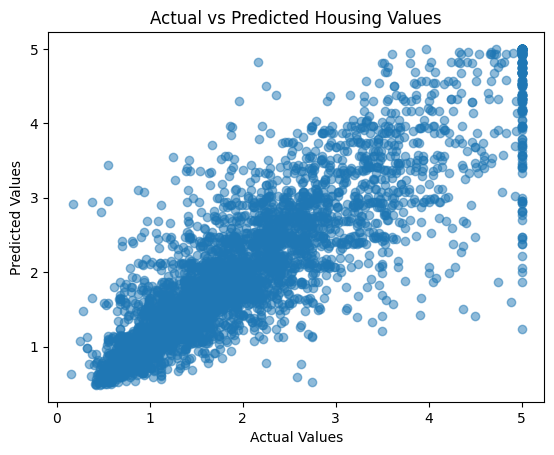

In [20]:
# Load the California housing dataset
df_housing = fetch_california_housing()
X, y = df_housing.data, df_housing.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create and train a Decision Tree regressor
# The following parameters greatly impact the Tree's ability to overfit the data:
# - max_depth: default=None
# - min_samples_split: default=2
# - min_samples_leaf: default=1
decision_tree = DecisionTreeRegressor(max_depth=None, min_samples_split=50, min_samples_leaf=10)
decision_tree.fit(X_train, y_train)

print("Max. Depth of Trained Tree: {}".format(decision_tree.tree_.max_depth))

# Make predictions on the training set
y_pred = decision_tree.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print("Mean Squared Error (Training): {}".format(mse))

# Make predictions on the test set
y_pred = decision_tree.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (Test): {}".format(mse))

# Plot the actual vs predicted values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Housing Values")
plt.show()
